# Deep Neural Network from Scratch
---
#### In this notebook, we will extend our understanding of neural networks by building two different architectures: a shallow neural network and a deep neural network. <br> Both will have the same number of nodes/neurons. 
#### The goal is to highlight the power of deeper architectures in modeling complex relationships within data.
---
This notebook assumes you are familiar with logistic regression, basic neural network concepts, matrix multiplication, and Gradient Descent, which I discussed in earlier notebooks [Logistic Regression from Scratch](https://github.com/vikrawar/from-scratch-logistic-regression) and [2-Layer NN from Scratch](https://github.com/vikrawar/2-layer-nn-from-scratch).

## Generating Training Data

To test our neural networks, we'll generate a synthetic dataset. This dataset will have 20 features for each training example and 1000 total examples. The labels will be binary (0 or 1), making it a binary classification problem.

We'll represent our features `X` as a matrix where each column is a training example, and `Y` as a row vector of corresponding binary labels.

X:
$$ \begin{bmatrix}
\vert & \vert & \vert & \dots & \vert \\
x^{(1)} & x^{(2)} & x^{(3)} & \dots & x^{(1000)} \\
\vert & \vert & \vert & \dots & \vert \\
\end{bmatrix} \qquad $$

Y: 
$$ \begin{bmatrix} y^{(1)} & y^{(2)} & y^{(3)} & \dots & y^{(1000)} \end{bmatrix} $$

Note on notation: <br>
Don't get hung up on the notation and terminology. 
Some people prefer to have the training data stacked as rows. 
At the end of the day, it doesn't matter as long as the Matrix multiplications work out.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

X = np.random.randn(20, 1000)
Y = (np.random.rand(1, 1000) > 0.5).astype(float)

print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

Shape of X: (20, 1000)
Shape of Y: (1, 1000)


## Activation Functions

Neural networks use activation functions to introduce non-linearity, allowing them to learn complex patterns.  <br>  
We'll use **Sigmoid** for our output layer for binary classification.  
We'll use **ReLU (Rectified Linear Unit)** as our activation function. The ReLU is the most popular activation function for neural networks, because it's computationally efficient. But more importantly, it adresses the shortcomings of the Sigmoid, namely, the problem of vanishing gradients. More about this in a later notebook

**Sigmoid function:**
$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$

**ReLU function:**
$$ \text{ReLU}(z) = \max(0, z) $$

We will also need their derivatives for the backpropagation step.

**Derivative of Sigmoid:**
$$ \sigma'(a) = a(1-a) $$

**Derivative of ReLU:**
$$ \text{ReLU}'(z) = \begin{cases} 1 & \text{if } z > 0 \\ 0 & \text{if } z \le 0 \end{cases} $$

In [2]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(A):
    return A * (1 - A)

def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

## Initializing Weights and Biases
 
With multiple layers, manually initializing weights and biases for each layer becomes cumbersome, specially so as we go deeper and deeper (SOTA NNs have ~100 layers!).  
We'll write a helper function to initialize these parameters for our deep network.

We'll store the weights and bias in a dictionary, accessible by `Wl` and `bl` where `l` is the layer number.

Note: We are using He initialization for the weights. It's been shown to work well with the ReLU activation function. But that's not the focus of this particular notebook.

In [3]:
def initialize_parameters(layer_dims):
    """
    Initializes weights and biases for all layers in the network.
    Arguments:
    layer_dims -- python list containing the dimensions of each layer in our network
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
    """
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(1 / layer_dims[l-1])
        parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))

    return parameters

## Loss and Cost

In [4]:
def loss(A, Y):
    # A = predicted probabilities
    # Y = true labels

    # 1e-8 is added to prevent accidental calculation of log(0)
    return -(Y*np.log(A+1e-8) + (1-Y)*np.log((1-A)+1e-8))

def cost(loss): 
    return np.average(loss)

## Neural Network Architectures for Comparison

We will now define and train two distinct neural network architectures to compare their performance. 
To give a fair chance to our shallow neural network, both will have the same number of nodes.

1.  **Shallow Network (NN1)**:
    * Input Layer: 20 nodes (matches `X.shape[0]`)
    * Hidden Layer 1: 256 nodes
    * Output Layer: 1 node (for binary classification)  <br>
<br>
2.  **Deep Network (NN2)**:
    * Input Layer: 20 nodes
    * Hidden Layer 1: 64 nodes
    * Hidden Layer 2: 64 nodes
    * Hidden Layer 3: 64 nodes
    * Hidden Layer 4: 64 nodes
    * Output Layer: 1 node

### Training the Shallow Network (NN1): `[20, 256, 1]`

In [14]:
def train_nn1(X, Y, epochs, lr):
    
    # Initializing weights and bias
    parameters = initialize_parameters([20, 256, 1])
    W1, b1 = parameters['W1'], parameters['b1']
    W2, b2 = parameters['W2'], parameters['b2']

    costs = []

    print("\n--- Training Shallow Network (NN1) ---")

    for epoch in range(epochs):
        
        # Forward Pass
        Z1 = W1 @ X + b1
        A1 = relu(Z1)
        Z2 = W2 @ A1 + b2
        A2 = sigmoid(Z2)

        # Backward Pass
        m = Y.shape[1] # Number of examples
        
        # Gradients for Output Layer (Layer 2)
        dZ2 = A2 - Y
        dW2 = (dZ2 @ A1.T) / m
        db2 = np.sum(dZ2, axis=1, keepdims=True) / m
        
        # Gradients for Hidden Layer (Layer 1)
        dA1 = W2.T @ dZ2
        dZ1 = dA1 * relu_derivative(Z1)
        dW1 = (dZ1 @ X.T) / m
        db1 = np.sum(dZ1, axis=1, keepdims=True) / m

        # Update Parameters
        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr * dW2
        b2 -= lr * db2

        # Tracking the cost
        the_cost = cost(loss(A2, Y))
        costs.append(the_cost)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {the_cost:.4f}")

    # Final prediction and accuracy
    Z1 = W1 @ X + b1
    A1 = relu(Z1)
    Z2 = W2 @ A1 + b2
    A2 = sigmoid(Z2)
    
    preds = (A2 > 0.5).astype(float)
    accuracy = np.mean(preds == Y)
    print(f"Final Accuracy (Shallow NN1): {accuracy*100:.2f}%")
    
    return costs

In [15]:
# Train our shallow neural network
costs_nn1 = train_nn1(X, Y, epochs=1001, lr=0.1)


--- Training Shallow Network (NN1) ---
Epoch 0: Loss = 0.7401
Epoch 100: Loss = 0.6449
Epoch 200: Loss = 0.6146
Epoch 300: Loss = 0.5880
Epoch 400: Loss = 0.5625
Epoch 500: Loss = 0.5377
Epoch 600: Loss = 0.5133
Epoch 700: Loss = 0.4890
Epoch 800: Loss = 0.4644
Epoch 900: Loss = 0.4394
Epoch 1000: Loss = 0.4138
Final Accuracy (Shallow NN1): 83.80%


### Training the Deep Network (NN2): `[20, 64, 64, 64, 64, 1]`

In [16]:
def train_nn2(X, Y, epochs, lr):

    # Initializing weights and bias
    parameters = initialize_parameters([20, 64, 64, 64, 64, 1])
    W1, b1 = parameters['W1'], parameters['b1']
    W2, b2 = parameters['W2'], parameters['b2']
    W3, b3 = parameters['W3'], parameters['b3']
    W4, b4 = parameters['W4'], parameters['b4']
    W5, b5 = parameters['W5'], parameters['b5']

    costs = []

    print("\n--- Training Deep Network (NN2) ---")

    for epoch in range(epochs):
        
        # Forward Pass
        Z1 = W1 @ X + b1
        A1 = relu(Z1)
        Z2 = W2 @ A1 + b2
        A2 = relu(Z2)
        Z3 = W3 @ A2 + b3
        A3 = relu(Z3)
        Z4 = W4 @ A3 + b4
        A4 = relu(Z4)
        Z5 = W5 @ A4 + b5
        A5 = sigmoid(Z5)

        # Backpropagation
        m = Y.shape[1] # Number of examples

        # Gradients for Output Layer (Layer 5)
        dZ5 = A5 - Y
        dW5 = (dZ5 @ A4.T) / m
        db5 = np.sum(dZ5, axis=1, keepdims=True) / m

        # Gradients for Layer 4
        dA4 = W5.T @ dZ5
        dZ4 = dA4 * relu_derivative(Z4)
        dW4 = (dZ4 @ A3.T) / m
        db4 = np.sum(dZ4, axis=1, keepdims=True) / m

        # Gradients for Layer 3
        dA3 = W4.T @ dZ4
        dZ3 = dA3 * relu_derivative(Z3)
        dW3 = (dZ3 @ A2.T) / m
        db3 = np.sum(dZ3, axis=1, keepdims=True) / m

        # Gradients for Layer 2
        dA2 = W3.T @ dZ3
        dZ2 = dA2 * relu_derivative(Z2)
        dW2 = (dZ2 @ A1.T) / m
        db2 = np.sum(dZ2, axis=1, keepdims=True) / m

        # Gradients for Layer 1
        dA1 = W2.T @ dZ2
        dZ1 = dA1 * relu_derivative(Z1)
        dW1 = (dZ1 @ X.T) / m
        db1 = np.sum(dZ1, axis=1, keepdims=True) / m

        # Gradient Descent
        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr * dW2
        b2 -= lr * db2
        W3 -= lr * dW3
        b3 -= lr * db3
        W4 -= lr * dW4
        b4 -= lr * db4
        W5 -= lr * dW5
        b5 -= lr * db5

        # # Tracking the cost
        the_cost = cost(loss(A5, Y))
        costs.append(the_cost)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {the_cost:.4f}")

    # Final prediction and accuracy
    Z1 = W1 @ X + b1
    A1 = relu(Z1)
    Z2 = W2 @ A1 + b2
    A2 = relu(Z2)
    Z3 = W3 @ A2 + b3
    A3 = relu(Z3)
    Z4 = W4 @ A3 + b4
    A4 = relu(Z4)
    Z5 = W5 @ A4 + b5
    A5 = sigmoid(Z5)
    
    preds = (A5 > 0.5).astype(float)
    accuracy = np.mean(preds == Y)
    print(f"Final Accuracy (Deep NN2): {accuracy*100:.2f}%")
    
    return costs

In [17]:
# Training our deep neural network
costs_nn2 = train_nn2(X, Y, epochs=1001, lr=0.1)


--- Training Deep Network (NN2) ---
Epoch 0: Loss = 0.7000
Epoch 100: Loss = 0.6793
Epoch 200: Loss = 0.6584
Epoch 300: Loss = 0.6137
Epoch 400: Loss = 0.5232
Epoch 500: Loss = 0.4797
Epoch 600: Loss = 0.2826
Epoch 700: Loss = 0.1785
Epoch 800: Loss = 0.1199
Epoch 900: Loss = 0.0373
Epoch 1000: Loss = 0.0169
Final Accuracy (Deep NN2): 100.00%


## Plotting the Cost

Let's visualize how the cost changed over training iterations for both the shallow and deep neural networks. This will give us insight into their learning progress and convergence.

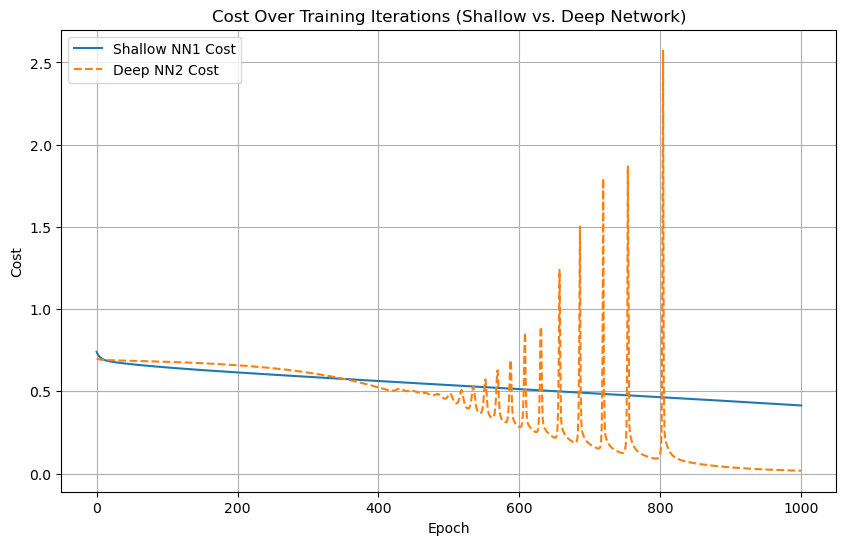

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(costs_nn1, label='Shallow NN1 Cost')
plt.plot(costs_nn2, label='Deep NN2 Cost', linestyle='--')
plt.title('Cost Over Training Iterations (Shallow vs. Deep Network)')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()

Notice the erratic spikes in the deep network after ~500 epochs. With more layers comes more problems. Thankfully, researchers have found out ways past this. <br>
But even without advanced tricks, our deep NN still manages to reach 100% accuracy, effectively memorizing the dataset.

## Wrap-Up

In this notebook, we built and compared two neural network architectures from scratch using NumPy:
-   A **shallow network** with one large hidden layer.
-   A **deep network** with multiple smaller hidden layers.

We observed firsthand that the deeper neural network is able to learn more complex and hierarchical representations of the data. This exercise demonstrates a core principle in deep learning: **depth matters**.

This exercise gave us a glimpse of why deep neural networks have become ubiquitous.

---

Thanks for following along! 🎉  
I hope this deep dive has further solidified your understanding of neural networks.
If you found this helpful, consider ⭐️ the repo or sharing it with someone learning deep learning.